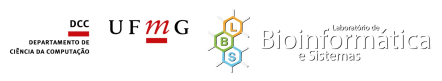

Federal University of Minas Gerais

Department of Computer Science

[Bioinformatics and Systems Laboratory](http://bioinfo.dcc.ufmg.br/)

Authors: Lucas Moraes, Diego Mariano and Prof. Dr. Raquel Cardoso de Melo-Minardi

In [1]:
dir_base = "./"

In [2]:
# Importing libraries
import os, shutil
from os import listdir, mkdir
from Bio import PDB
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def distance_maps(chain_coordinates, peptide_class, pdb_file):
    """
    Generate and save a distance map from protein and peptide coordinates.
    
    Parameters:
    - chain_coordinates: Dictionary containing the coordinates of the chains.
    - peptide_class: Classification of the peptide used for directory structuring.
    - pdb_file: The filename of the PDB structure being processed.
    
    This function calculates the Euclidean distance between each peptide residue
    and each protein atom, saving the resulting matrices as an distance map.
    """
    
    filename = pdb_file.split('.')[0]
    
    # Get the protein and peptide coordinates using slicing
    _, coords_prot = list(chain_coordinates.items())[0]
    _, coords_pep = list(chain_coordinates.items())[1]
    peptide_size = np.shape(coords_pep)[0]
    interface_size = np.shape(coords_prot)[0]
    
    # protein-peptide interaction map
    m = np.zeros(shape=(peptide_size, interface_size))
    i = 0
    for a in coords_pep:
        m[i] = list(map(lambda b: np.linalg.norm(a-b), coords_prot))
        i += 1

    if not os.path.isdir(dir_base+'Pep-PI maps/'+peptide_class):
        mkdir(dir_base+'Pep-PI maps/'+peptide_class)

    plt.imsave(dir_base+'Pep-PI maps/'+peptide_class+'/'+filename+'.png', m, cmap='plasma', origin='lower')

In [ ]:
def create_dataset_sequencias():
    """
    This function reads a CSV file containing experimental data, extracts the labels relating to the peptide classes,
    and reorganizes the PDBs into categorized directories.
    """
    
    interfaces_dir = os.path.join(dir_base, 'interface')
    interfaces = listdir(interfaces_dir)
    df = pd.read_csv(os.path.join(dir_base, 'experimental_data_1_cutoff_0_2_max_20.csv'))

    for i in range(df.shape[0]):
        classe = df.iloc[i, 0].split('/')[1]
        peptideo = os.path.splitext(df.iloc[i, 0].split('/')[2])[0]
        interface_class_dir = os.path.join(dir_base, 'sequence-clusters', classe)
        if not os.path.exists(interface_class_dir):
            os.mkdir(interface_class_dir)

        files = list(filter(lambda x: peptideo in x, interfaces))
        for f in files:
            if os.path.isfile(os.path.join(dir_base, 'interface', f)):
                shutil.move(os.path.join(dir_base, 'interface', f), os.path.join(dir_base, 'sequence-clusters', classe, f))
                interfaces.remove(f)

In [4]:
def create_dataset_subclasses():
    """
    This function reads a CSV file containing experimental data, extracts the labels relating to the peptide classes,
    and reorganizes the PDBs into categorized directories.
    """
    
    interfaces_dir = os.path.join(dir_base, 'interface')
    interfaces = listdir(interfaces_dir)
    df = pd.read_csv(os.path.join(dir_base, 'experimental_data_2_cutoff_0_2_max_20.csv'))

    for i in range(df.shape[0]):
        classe = df['cluster'][i]
        peptideo = df['peptide'][i].split(' ')[1].replace('(', '').replace(')', '').replace(':', '_')
        interface_class_dir = os.path.join(dir_base, 'subclasses-clusters', classe)
        if not os.path.exists(interface_class_dir):
            os.mkdir(interface_class_dir)

        files = list(filter(lambda x: peptideo in x, interfaces))
        for f in files:
            if os.path.isfile(os.path.join(dir_base, 'interface', f)):
                shutil.move(os.path.join(dir_base, 'interface', f), os.path.join(dir_base, 'subclasses-clusters', classe, f))
                interfaces.remove(f)

In [5]:
create_dataset_subclasses()

In [9]:
from Bio import PDB

# Create a PDB parser
parser = PDB.PDBParser(QUIET=True)

# Check if the base directory exists
if not os.path.exists(dir_base):
    raise FileNotFoundError(f"The base directory {dir_base} does not exist")

interfaces_dir = os.path.join(dir_base, "Sub-categorias")

# Check if the interfaces directory exists
if not os.path.exists(interfaces_dir):
    raise FileNotFoundError(f"The interfaces directory {interfaces_dir} does not exist")

for peptide_class in os.listdir(interfaces_dir):
    dir_path = os.path.join(interfaces_dir, peptide_class)

    # Check if the peptide class directory exists
    if not os.path.exists(dir_path):
        print(f"Directory {dir_path} does not exist")
        continue

    for pdb in os.listdir(dir_path):
        pdb_file_path = os.path.join(dir_path, pdb)

        try:
            structure = parser.get_structure("PDBStructure", pdb_file_path)
        except Exception as e:
            print(f"Failed to parse {pdb_file_path}: {e}")
            continue
            
        chain_coordinates = {}
        for model in structure:
            for chain in model:
                chain_id = chain.id
                if chain_id not in chain_coordinates:
                    chain_coordinates[chain_id] = []

                for residue in chain:
                    for atom in residue:
                        chain_coordinates[chain_id].append(atom.get_coord())

        # Convert lists of coordinates to NumPy arrays
        for chain_id in chain_coordinates:
            chain_coordinates[chain_id] = np.array(chain_coordinates[chain_id])

        distance_maps(chain_coordinates, peptide_class, pdb)